# First Deep Learning Model


## Importing Libraries and Dataset


In [ ]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing the dataset
from datasets import load_dataset

mnist_dataset = load_dataset("mnist")

mnist_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

What the hell is this? You may ask. This is just [Hugging Face's](https://huggingface.co/docs/datasets/index) `datasets` library, which provides a simple way to access and share datasets. `DatasetDict` is a dictionary-like class that holds multiple datasets, typically a training set, validation set, and test set.

Okay, so now we have the MNIST dataset, which is a classic in the machine learning world. It consists of 70,000 images of handwritten digits (0-9), each image being 28x28 pixels in size. The dataset is split into 60,000 training images and 10,000 test images.

In order to use this dataset, you can access the training and test splits as follows:


In [10]:
# Access the training and test splits
train_dataset = mnist_dataset["train"]
test_dataset = mnist_dataset["test"]

# You can then explore the dataset, for example:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Example training sample: {train_dataset[0]}")

Number of training samples: 60000
Number of test samples: 10000
Example training sample: {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x23E19ACEAD0>, 'label': 5}


Hmmm... let's visualize some of the training samples to get a better understanding of the dataset, because what the hell is `PIL.PngImagePlugin.PngImageFile`?


In [ ]:
def visualize_samples(dataset, num_samples=10, cols=5, is_random=False):
    """
    Visualize samples from the dataset.

    Args:
        dataset: HuggingFace dataset object
        num_samples: Number of samples to display
        cols: Number of columns in the grid
        is_random: Whether to display random samples
    """
    # Calculate number of rows needed
    rows = (num_samples + cols - 1) // cols

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

    # Handle case when there's only one row or column
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Generate indices: random or sequential
    if is_random:
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    else:
        indices = range(num_samples)

    # Display images
    for i, idx in enumerate(indices):
        # Get image and label from dataset
        sample = dataset[idx]
        image = sample["image"]
        label = sample["label"]

        # Display the image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    # Hide extra subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

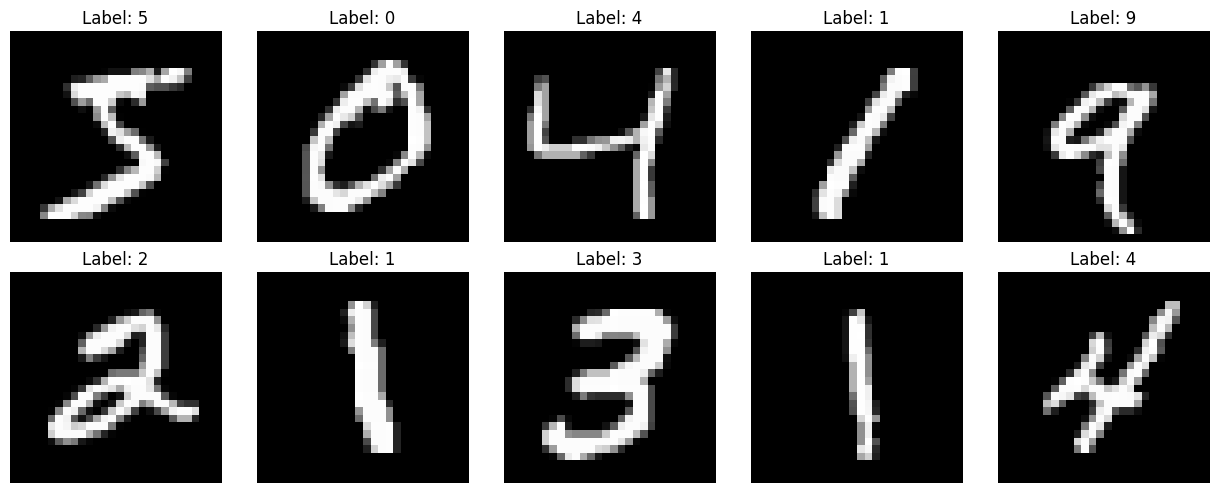

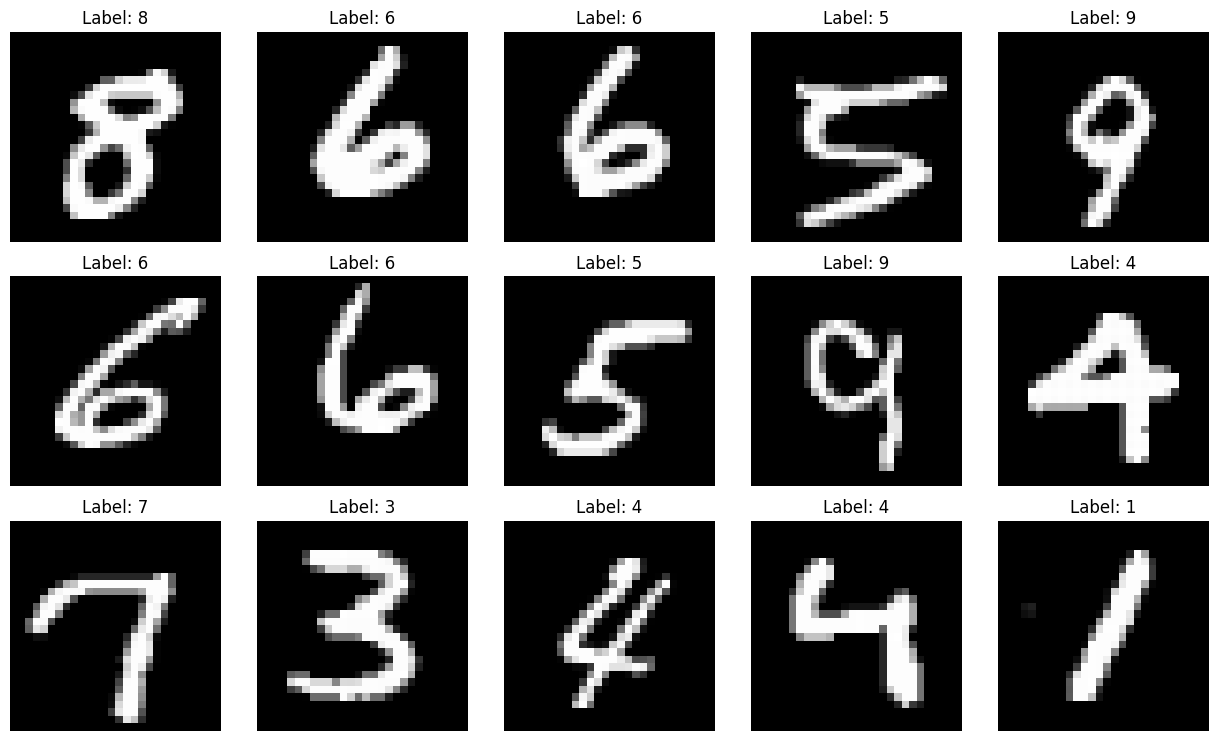

In [30]:
visualize_samples(train_dataset, num_samples=10, cols=5, is_random=False)
visualize_samples(train_dataset, num_samples=15, cols=5, is_random=True)

Hooray! We can see that the images are indeed handwritten digits, and the labels correspond to the correct digit for each image.

That is what we will work on now. And first, let's define a problem and think of a solution...

## Problem Definition

Imagine you are working in a postal service, and you need to sort letters based on the handwritten zip codes. Manually sorting these letters is time-consuming and prone to errors. To automate this process, you decide to build a machine learning model that can recognize handwritten digits from images 28x28 pixels in size.

So, the problem we are trying to solve is: **Given an image of a handwritten digit, classify it into one of the 10 classes (0-9)**.

What kind of model can we use to solve this problem? Think of some simple algorithms that can classify black and white images this way.